In [ ]:
!pip3 install tomotopy
!pip3 install pymupdf
!pip3 install nltk

In [1]:
import os
import fitz
import tomotopy as tp
from tomotopy.coherence import Coherence
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Set custom stopwords
custom_stopwords = set(stopwords.words('english')).union(set([
    'also', 'including', 'shall', 'body', 'article', 'ai', 'system', 'cod',
    'artificial', 'intelligence', 'etc', 'may', 'use', 'within', 'must', 'could',
    'state', 'national', 'eu', 'usa', 'us', 'prc', 'regulation', 'law', 'com',
    'eli', 'http', 'set', 'put', 'b', 'sep', 'nov', 'jkt', 'po', 'frm', 'fmt',
    'sfmt', 'e', 'en', 'swd', 'vol', 'sec', 'iii', 'c', 'ii', 'i', 'https',
    'title', 'chapter', 'title', 'section', 'cc', 'de', 'europe', 'see',
    'del', 'l', 'et', 'act', 'r', 'n', 'p', 'f', 'h', 'u', 'new', 'data',
    'used', 'would'

]))

warnings.filterwarnings("ignore", category=UserWarning)

def preprocess(doc):
    """
    Preprocess the document by converting text to lowercase, tokenizing, and removing stopwords and non-alphabetic tokens.
    """
    doc = doc.lower()
    tokens = word_tokenize(doc)
    tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
    return tokens

def load_documents(folder_path):
    """
    Load and preprocess documents from the given folder path.
    """
    documents = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            try:
                doc = fitz.open(os.path.join(folder_path, filename))
                text = ""
                for page in doc:
                    text += page.get_text()
                documents.append(preprocess(text))
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    return documents

def calculate_tfidf(documents):
    """
    Calculate the TF-IDF scores for the given documents.
    """
    documents = [' '.join(doc) for doc in documents]
    tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess)
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = {}
    for doc_index in range(tfidf_matrix.shape[0]):
        feature_index = tfidf_matrix[doc_index, :].nonzero()[1]
        tfidf_doc_scores = zip(feature_index, [tfidf_matrix[doc_index, x] for x in feature_index])
        for word_index, score in tfidf_doc_scores:
            word = feature_names[word_index]
            tfidf_scores[word] = tfidf_scores.get(word, 0) + score
    return tfidf_scores

def run_seeded_lda_with_tfidf(documents, num_topics, seed_topic_list, tfidf_scores, top_n_tfidf=10):
    """
    Run Seeded LDA with TF-IDF seed words on the given documents.
    """
    model = tp.LDAModel(k=num_topics, alpha=0.1, eta=0.01, min_cf=5)
    for doc in documents:
        model.add_doc(doc)

    # Enhance the seed_topic_list with highest TF-IDF words
    for topic_id, (topic, seed_words) in enumerate(seed_topic_list.items()):
        for word in seed_words:
            if word in model.used_vocabs:
                word_id = model.used_vocabs[word]
                model.set_word_prior(topic_id, word_id, 1.0)

        # Add top N TF-IDF words to the seed words
        top_tfidf_words = sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True)[:top_n_tfidf]
        tfidf_seed_words = [word for word, score in top_tfidf_words if word not in seed_words]

        for word in tfidf_seed_words:
            if word in model.used_vocabs:
                word_id = model.used_vocabs[word]
                model.set_word_prior(topic_id, word_id, 0.5)

    iterations = 25
    for i in range(0, 800, iterations):
        model.train(iterations)
        print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')
    return model

def calculate_coherence(model):
    """
    Calculate the coherence of the given model.
    """
    coherence = Coherence(model, coherence='c_v')
    return coherence.get_score()

def calculate_inclusivity(model):
    """
    Calculate the inclusivity of the given model.
    """
    topic_counts = np.zeros(model.k)
    for doc in model.docs:
        for t, _ in doc.get_topics():
            topic_counts[t] += 1
    return topic_counts / len(model.docs)

# Load documents
document_paths = {'EU': 'EU', 'USA': 'USA', 'PRC': 'PRC'}
documents = {region: load_documents(path) for region, path in document_paths.items()}

# Calculate TF-IDF scores
tfidf_scores = {region: calculate_tfidf(docs) for region, docs in documents.items()}

# Define seed topics
seed_topic_list = {
    'sustainability': ['sustainability', 'sustainable', 'eco-friendly', 'green', 'eco'],
    'environmental_impact': ['environment', 'environmental', 'impact', 'carbon', 'footprint', 'greenhouse', 'climate'],
    'energy_demand': ['resource', 'demand', 'consumption', 'energy', 'electricity', 'use']
}

# Run the topic modeling and print results
num_topics = 5 # Number of topics
num_topic_words = 20 # Number of top words per topic
top_n_tfidf = 10  # Number of top TF-IDF words to add to seed topics
results_tfidf = {}
topics = {}

for region, docs in documents.items():
    print(f"\nProcessing region: {region}")
    model_tfidf = run_seeded_lda_with_tfidf(docs, num_topics, seed_topic_list, tfidf_scores[region], top_n_tfidf)
    coherence_tfidf = calculate_coherence(model_tfidf)
    perplexity_tfidf = model_tfidf.perplexity
    inclusivity_tfidf = calculate_inclusivity(model_tfidf)
    
    results_tfidf[region] = {
        'model': model_tfidf, 
        'coherence': coherence_tfidf, 
        'perplexity': perplexity_tfidf, 
        'inclusivity': inclusivity_tfidf
    }

    print(f"\nTOPICS for {region}:\n")
    topics[region] = {}
    for topic_number in range(num_topics):
        topic_words_tfidf = [word for word, _ in model_tfidf.get_topic_words(topic_number, top_n=num_topic_words)]
        topics[region][topic_number] = topic_words_tfidf
        print(f"Topic {topic_number + 1}: {' '.join(topic_words_tfidf)}")

    # Print coherence, perplexity, and inclusivity
    print(f'\nCoherence: {coherence_tfidf}')
    print(f'Perplexity: {perplexity_tfidf}')
    print(f'Inclusivity: {inclusivity_tfidf}')

    # Save and load the model
    model_path = f'{region}_model_tfidf.bin'
    model_tfidf.save(model_path)
    loaded_model_tfidf = tp.LDAModel.load(model_path)
    print(f'Model for {region} saved and loaded successfully.')


[nltk_data] Downloading package punkt to /Users/Janek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Janek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Processing region: EU
Iteration: 0	Log-likelihood: -7.946063772609516
Iteration: 25	Log-likelihood: -7.870790383237139
Iteration: 50	Log-likelihood: -7.83446164472147
Iteration: 75	Log-likelihood: -7.820011023549269
Iteration: 100	Log-likelihood: -7.813988562368697
Iteration: 125	Log-likelihood: -7.811809563472849
Iteration: 150	Log-likelihood: -7.8108359427088585
Iteration: 175	Log-likelihood: -7.805661697114418
Iteration: 200	Log-likelihood: -7.805528437339073
Iteration: 225	Log-likelihood: -7.8001841215968435
Iteration: 250	Log-likelihood: -7.802097494336408
Iteration: 275	Log-likelihood: -7.798565994013141
Iteration: 300	Log-likelihood: -7.796982773870332
Iteration: 325	Log-likelihood: -7.8000007253774495
Iteration: 350	Log-likelihood: -7.798975656344723
Iteration: 375	Log-likelihood: -7.796798910351573
Iteration: 400	Log-likelihood: -7.7993359987675355
Iteration: 425	Log-likelihood: -7.799031860553113
Iteration: 450	Log-likelihood: -7.798092413629345
Iteration: 475	Log-likelihood

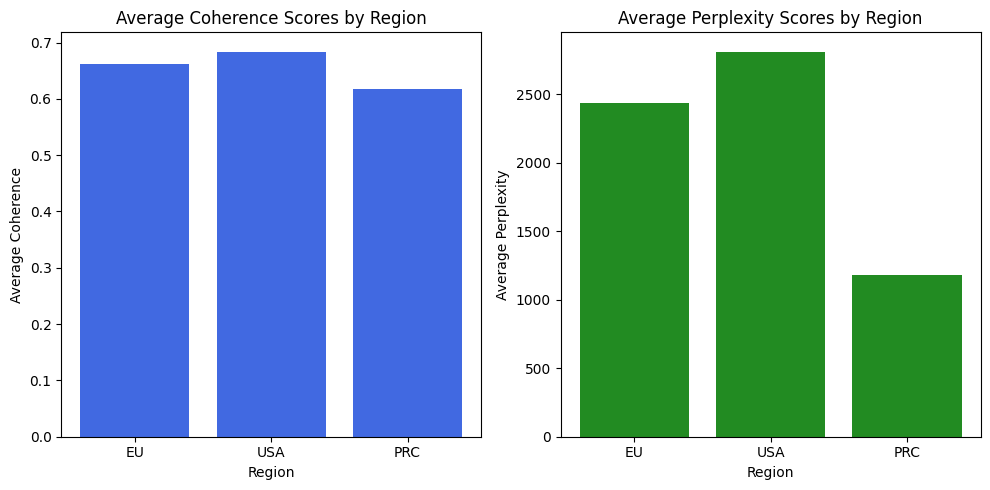

In [2]:
def plot_average_scores(results_tfidf):
    """
    Plots the average coherence, perplexity, and inclusivity scores for the given models across regions.

    Parameters:
    results_tfidf (dict): A dictionary where the key is the region and the value is a dictionary containing the trained model and its metrics.

    Returns:
    This function plots the average scores.
    """
    regions = list(results_tfidf.keys())
    coherence_scores = [results_tfidf[region]['coherence'] for region in regions]
    perplexity_scores = [results_tfidf[region]['perplexity'] for region in regions]

    # Plotting the average scores
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.bar(regions, coherence_scores, color='royalblue')
    plt.xlabel('Region')
    plt.ylabel('Average Coherence')
    plt.title('Average Coherence Scores by Region')

    plt.subplot(1, 3, 2)
    plt.bar(regions, perplexity_scores, color='forestgreen')
    plt.xlabel('Region')
    plt.ylabel('Average Perplexity')
    plt.title('Average Perplexity Scores by Region')

    plt.tight_layout()
    plt.show()

# Plot the average scores for the tf-idf enhanced models
plot_average_scores(results_tfidf)



==== Coherence for EU: c_v ====
Average: 0.6625511175021529
Minimum: 0.49308337569236754
Maximum: 0.9096847712993622

Per Topic:
Topic 1: 0.647138854674995
Topic 2: 0.9096847712993622
Topic 3: 0.6230028182268142
Topic 4: 0.6398457676172257
Topic 5: 0.49308337569236754

==== Coherence for USA: c_v ====
Average: 0.6839218881726266
Minimum: 0.5644290626049042
Maximum: 0.7993654817342758

Per Topic:
Topic 1: 0.6182792082428932
Topic 2: 0.5644290626049042
Topic 3: 0.7993654817342758
Topic 4: 0.6803451389074325
Topic 5: 0.7571905493736267

==== Coherence for PRC: c_v ====
Average: 0.6173033990710974
Minimum: 0.43761161118745806
Maximum: 0.7646967649459839

Per Topic:
Topic 1: 0.6121282633394003
Topic 2: 0.7646967649459839
Topic 3: 0.43761161118745806
Topic 4: 0.7451742649078369
Topic 5: 0.5269060909748078

Average coherence across all regions: 0.6545921349152922



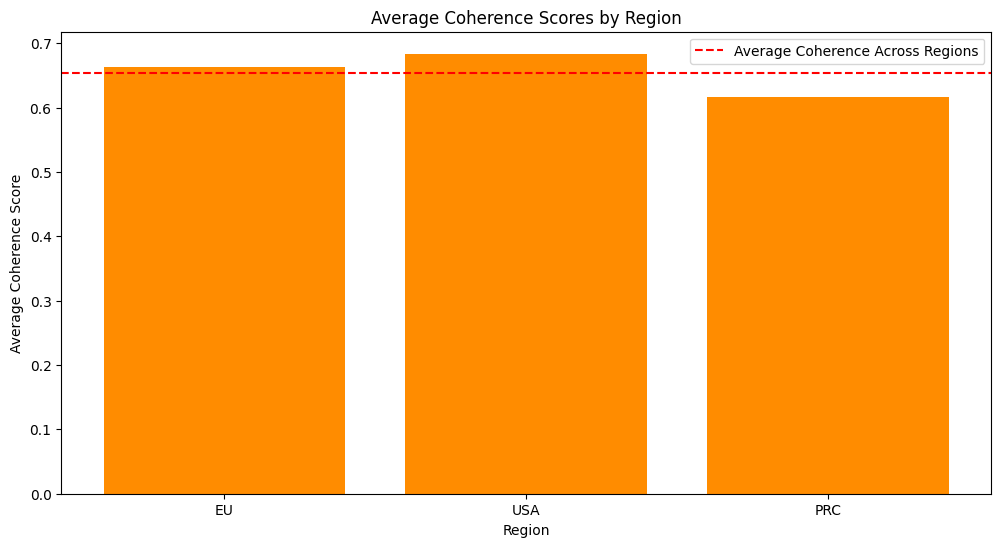

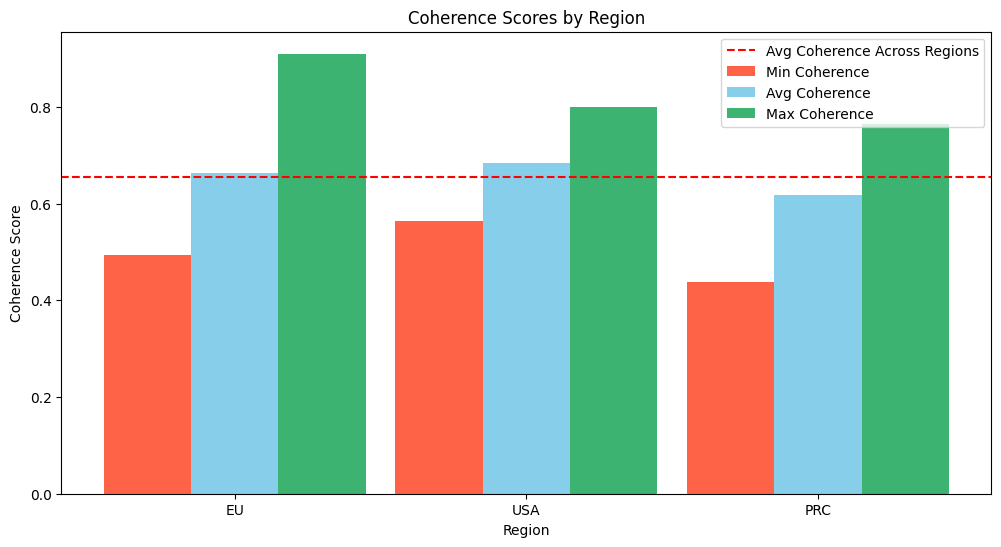

In [3]:
# Calculate coherence for each document set, print metrics, and plot
coherences = {}
min_coherences = {}
max_coherences = {}

for region, result in results_tfidf.items():
    model = result['model']
    coherence = tp.coherence.Coherence(model, coherence='c_v')
    average_coherence = coherence.get_score()
    coherence_per_topic = [coherence.get_score(topic_id=k) for k in range(model.k)]
    min_coherence = min(coherence_per_topic)
    max_coherence = max(coherence_per_topic)
    
    print(f'\n==== Coherence for {region}: c_v ====')
    print('Average:', average_coherence)
    print('Minimum:', min_coherence)
    print('Maximum:', max_coherence)
    print('\nPer Topic:')
    for i, score in enumerate(coherence_per_topic):
        print(f'Topic {i + 1}: {score}')
    
    coherences[region] = average_coherence
    min_coherences[region] = min_coherence
    max_coherences[region] = max_coherence

# Calculate the average coherence across all regions
average_coherence_total = np.mean(list(coherences.values()))
print(f'\nAverage coherence across all regions: {average_coherence_total}\n')

# Plot average coherence scores by region
plt.figure(figsize=(12, 6))
plt.bar(coherences.keys(), coherences.values(), color='darkorange')
plt.axhline(y=average_coherence_total, color='r', linestyle='--', label='Average Coherence Across Regions')
plt.xlabel('Region')
plt.ylabel('Average Coherence Score')
plt.title('Average Coherence Scores by Region')
plt.legend()
plt.show()

# Plot minimum and maximum coherence scores by region
plt.figure(figsize=(12, 6))
x = np.arange(len(coherences))
width = 0.3

plt.bar(x - width, min_coherences.values(), width, label='Min Coherence', color='tomato')
plt.bar(x, coherences.values(), width, label='Avg Coherence', color='skyblue')
plt.bar(x + width, max_coherences.values(), width, label='Max Coherence', color='mediumseagreen')

plt.axhline(y=average_coherence_total, color='r', linestyle='--', label='Avg Coherence Across Regions')
plt.xlabel('Region')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores by Region')
plt.xticks(x, coherences.keys())
plt.legend()
plt.show()

In [4]:
# Combine documents from all regions
all_docs = {'EU': documents['EU'], 'USA': documents['USA'], 'PRC': documents['PRC']}
all_models = {'EU': results_tfidf['EU']['model'], 'USA': results_tfidf['USA']['model'], 'PRC': results_tfidf['PRC']['model']}

# Function to calculate topic distributions
def calculate_topic_distributions(model, docs):
    topic_distributions = []
    for doc in docs:
        topic_dist, _ = model.infer(model.make_doc(doc))
        topic_distributions.append(topic_dist)
    return topic_distributions

# Get topic distributions for all regions
all_topic_distributions = {region: calculate_topic_distributions(all_models[region], docs) for region, docs in all_docs.items()}

# Determine the best performing documents for each topic in each region
best_docs_per_topic = {region: [] for region in all_docs.keys()}

for topic_number in range(5):  # Assuming 5 topics
    for region, topic_distributions in all_topic_distributions.items():
        docs = all_docs[region]
        sorted_docs = sorted([(dist[topic_number], i) for i, dist in enumerate(topic_distributions)], reverse=True, key=lambda x: x[0])
        best_docs_per_topic[region].append((topic_number, sorted_docs[:5]))  # Get top 5 documents

# Print results
for region, topics_docs in best_docs_per_topic.items():
    print(f"\nRegion: {region}")
    for topic_number, docs in topics_docs:
        print(f"\nTOPIC {topic_number}")
        for prob, doc_num in docs:
            print(f'Document Number: {doc_num}, Topic Probability: {prob:.4f}')

# Compare regions to find which one has the highest average topic probability for each topic
best_region_per_topic = {}

for topic_number in range(5):  # Assuming 5 topics
    best_region = None
    best_prob = 0
    for region, topic_distributions in all_topic_distributions.items():
        avg_prob = np.mean([dist[topic_number] for dist in topic_distributions])
        if avg_prob > best_prob:
            best_prob = avg_prob
            best_region = region
    best_region_per_topic[topic_number] = best_region

print("\nBest Region for Each Topic:")
for topic_number, region in best_region_per_topic.items():
    print(f"Topic {topic_number}: {region}")



Region: EU

TOPIC 0
Document Number: 50, Topic Probability: 0.7134
Document Number: 24, Topic Probability: 0.5818
Document Number: 15, Topic Probability: 0.4467
Document Number: 40, Topic Probability: 0.3992
Document Number: 33, Topic Probability: 0.3483

TOPIC 1
Document Number: 7, Topic Probability: 0.7860
Document Number: 4, Topic Probability: 0.2359
Document Number: 9, Topic Probability: 0.1060
Document Number: 43, Topic Probability: 0.0980
Document Number: 45, Topic Probability: 0.0375

TOPIC 2
Document Number: 2, Topic Probability: 0.9143
Document Number: 27, Topic Probability: 0.8903
Document Number: 51, Topic Probability: 0.8763
Document Number: 16, Topic Probability: 0.8634
Document Number: 26, Topic Probability: 0.7364

TOPIC 3
Document Number: 28, Topic Probability: 0.8575
Document Number: 36, Topic Probability: 0.8243
Document Number: 42, Topic Probability: 0.7999
Document Number: 13, Topic Probability: 0.7851
Document Number: 20, Topic Probability: 0.7479

TOPIC 4
Documen

In [5]:
from gensim.models import Word2Vec

def train_word2vec_model(documents):
    """
    Train a Word2Vec model on the given documents.
    """
    return Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

def get_topics(model, num_topics, num_topic_words):
    """
    Retrieve topics and their top words from the LDA model.
    """
    topics = {}
    for topic_id in range(num_topics):
        words = model.get_topic_words(topic_id, top_n=num_topic_words)
        topics[topic_id] = [word for word, _ in words]
    return topics

def explore_semantic_relationships(word2vec_model, topics):
    """
    Explore the semantic relationships between words within the identified topics using Word2Vec.
    """
    for topic_num, words in topics.items():
        print(f"Topic {topic_num + 1}:")
        for word in words:
            if word in word2vec_model.wv.key_to_index:
                similar_words = word2vec_model.wv.most_similar(word, topn=10)
                print(f"  {word}: {[w for w, _ in similar_words]}")
            else:
                print(f"  {word} not in vocabulary")
        print("\n")

def most_similar_and_distance(word2vec_model, word, word1, word2):
    """
    Find most similar words to a specified word and calculate distance between two specified words.
    """
    if word in word2vec_model.wv.key_to_index:
        most_similar_words = word2vec_model.wv.most_similar(word)
        print(f"Words most similar to '{word}':")
        for similar_word, similarity in most_similar_words:
            print(f"{similar_word}: {similarity}")
    else:
        print(f"Word '{word}' not in vocabulary")
    
    if word1 in word2vec_model.wv.key_to_index and word2 in word2vec_model.wv.key_to_index:
        distance = word2vec_model.wv.distance(word1, word2)
        print(f"Distance between '{word1}' and '{word2}': {distance}")
    else:
        print(f"One or both words '{word1}' and '{word2}' not in vocabulary")

# Assuming 'documents' and 'results_tfidf' are loaded from previous cell
num_topics = 5
num_topic_words = 15

# Train and save the word2vec models for each region
word2vec_models = {}

for region, docs in documents.items():
    print(f"\nExploring semantic relationships for region: {region}")
    word2vec_model = train_word2vec_model(docs)
    word2vec_models[region] = word2vec_model  # Save the model for later use
    
    lda_model = results_tfidf[region]['model']
    topics = get_topics(lda_model, num_topics, num_topic_words)
    
    explore_semantic_relationships(word2vec_model, topics)
    
    # Example analysis for specific words
    word = 'sustainability'
    word1 = 'sustainability'
    word2 = 'technology'
    most_similar_and_distance(word2vec_model, word, word1, word2)

# At this point, word2vec_models should contain the trained models



Exploring semantic relationships for region: EU
Topic 1:
  brain: ['summarise', 'treatments', 'advances', 'atlases', 'simulation', 'machine', 'many', 'circuitry', 'exposing', 'models']
  scientific: ['sam', 'advice', 'peter', 'policy', 'chief', 'science', 'ethics', 'group', 'ege', 'advisors']
  project: ['collaborations', 'years', 'five', 'flagship', 'year', 'comprised', 'top', 'per', 'dssc', 'ten']
  hbp: ['recent', 'figure', 'ati', 'vision', 'foresight', 'trends', 'flagship', 'bridging', 'survey', 'next']
  research: ['rtos', 'innovation', 'excellence', 'industry', 'partnership', 'investment', 'centre', 'community', 'maximised', 'centres']
  computing: ['edge', 'performance', 'infrastructures', 'quantum', 'advanced', 'cloud', 'supercomputing', 'neuromorphic', 'smart', 'connectivity']
  advanced: ['smart', 'big', 'iot', 'edge', 'additive', 'corridors', 'generation', 'value', 'novel', 'manufacturing']
  policy: ['ethics', 'ege', 'outlines', 'recommendations', 'peter', 'white', 'paper'

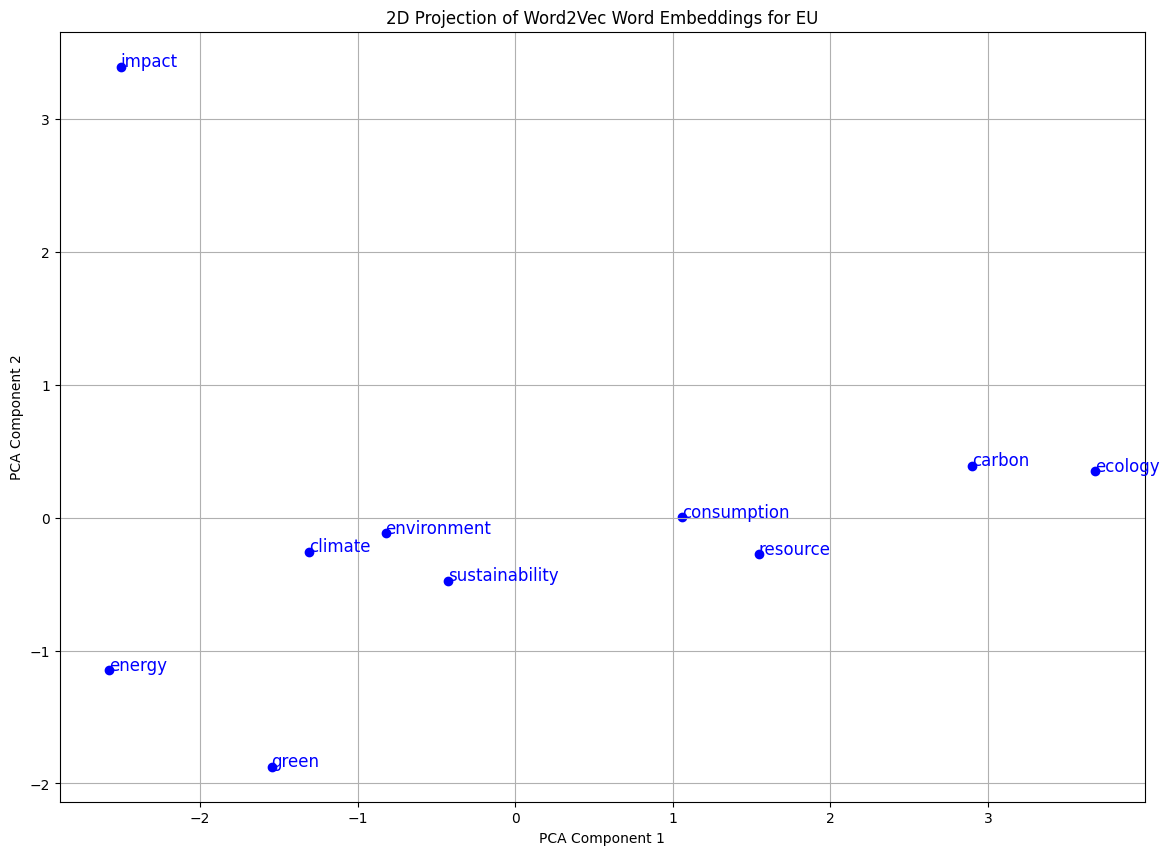

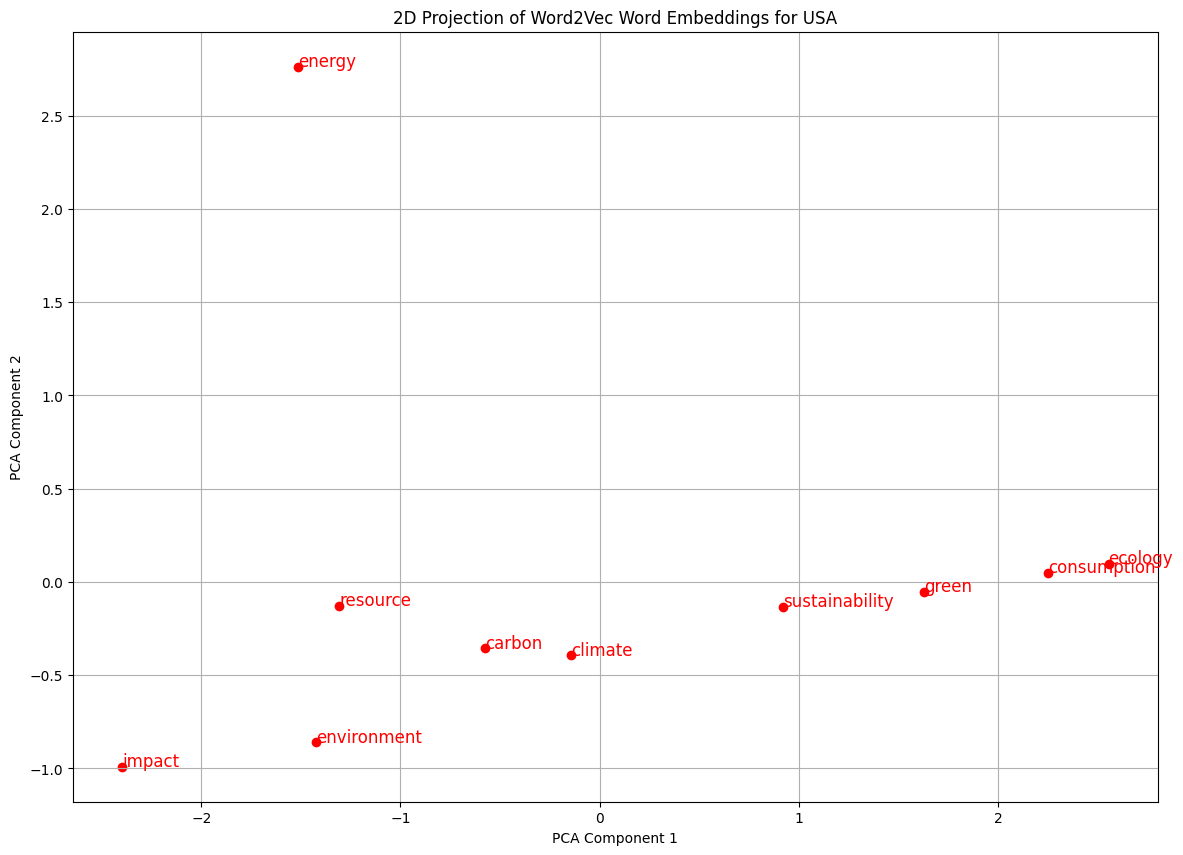

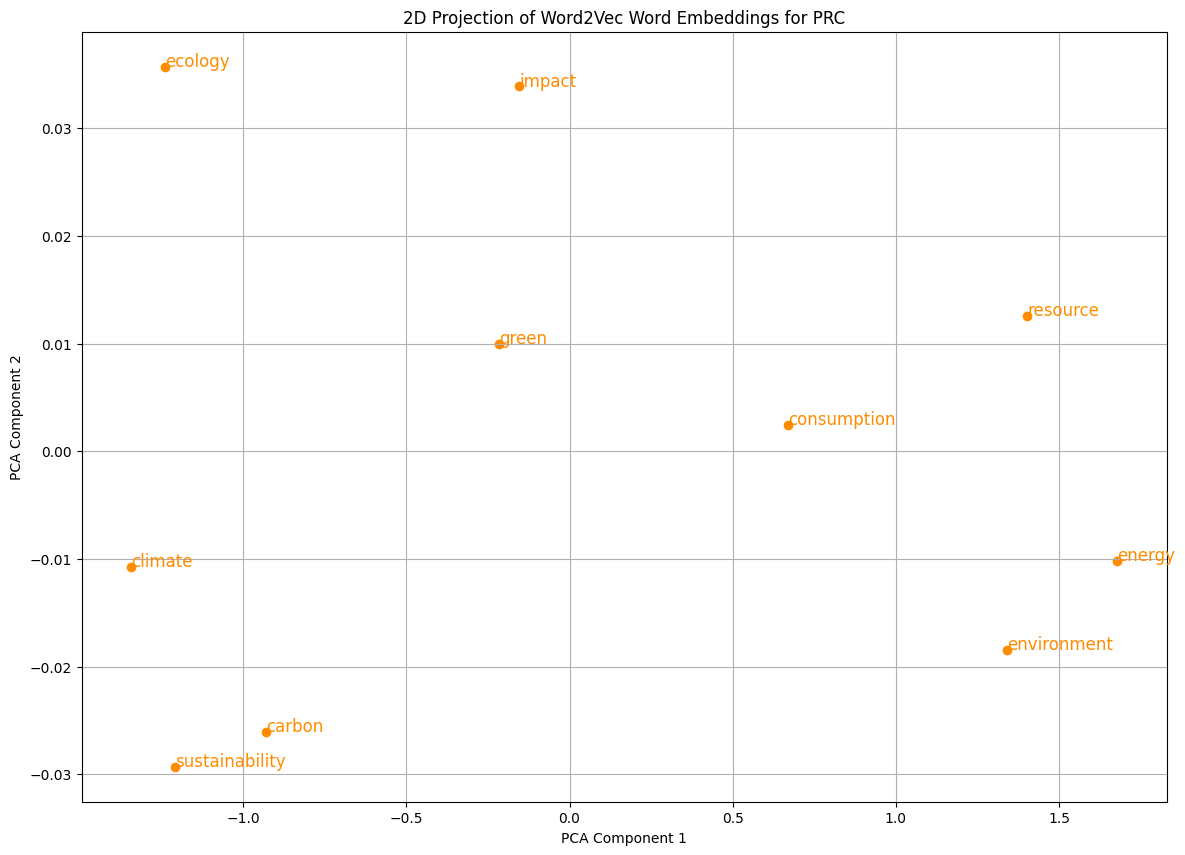

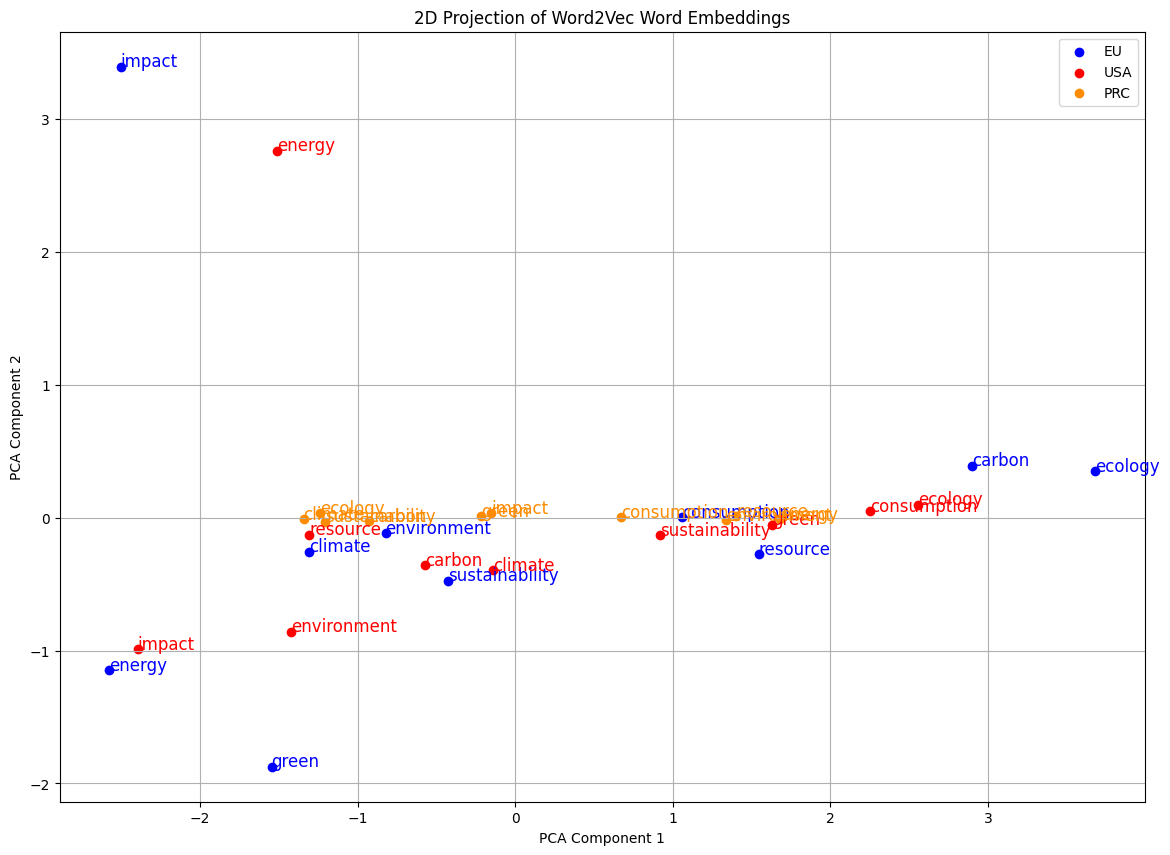

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_individual_projections(word2vec_models, words, regions):
    """
    Plot individual 2D projections of the word vectors using PCA for each region.
    """
    for region in regions:
        if region in word2vec_models:
            word2vec_model = word2vec_models[region]
            word_vectors = []
            valid_words = []

            for word in words:
                if word in word2vec_model.wv.key_to_index:
                    word_vectors.append(word2vec_model.wv[word])
                    valid_words.append(word)
                else:
                    print(f"Word '{word}' not found in {region} vocabulary.")

            if len(word_vectors) == 0:
                print(f"No words found in {region} vocabulary for projection.")
                continue

            pca = PCA(n_components=2)
            word_vectors_2d = pca.fit_transform(word_vectors)

            plt.figure(figsize=(14, 10))
            color = 'blue' if region == 'EU' else 'red' if region == 'USA' else 'darkorange'
            
            for i, word in enumerate(valid_words):
                plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], c=color)
                plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, color=color)
            
            plt.title(f'2D Projection of Word2Vec Word Embeddings for {region}')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.grid(True)
            plt.show()

def plot_combined_projection(word2vec_models, words, regions):
    """
    Plot a combined 2D projection of the word vectors using PCA for multiple regions.
    """
    plt.figure(figsize=(14, 10))
    
    # Custom colors for specified regions
    region_colors = {
        'EU': 'blue',
        'USA': 'red',
        'PRC': 'darkorange'
    }
    
    for idx, (region, word2vec_model) in enumerate(word2vec_models.items()):
        if region not in regions:
            continue
        
        word_vectors = []
        valid_words = []
        
        for word in words:
            if word in word2vec_model.wv.key_to_index:
                word_vectors.append(word2vec_model.wv[word])
                valid_words.append(word)
            else:
                print(f"Word '{word}' not found in {region} vocabulary.")

        if len(word_vectors) == 0:
            print(f"No words found in {region} vocabulary for projection.")
            continue

        pca = PCA(n_components=2)
        word_vectors_2d = pca.fit_transform(word_vectors)

        color = region_colors.get(region, 'black')  # Default color is black if region is not in region_colors
        
        for i, word in enumerate(valid_words):
            plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], c=color, label=region if i == 0 else "")
            plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=12, color=color)
    
    plt.title('2D Projection of Word2Vec Word Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

# Example usage
words_to_plot = ['sustainability', 'environment', 'green', 'energy', 'climate', 'ecology', 'impact', 'carbon', 'resource', 'consumption']
regions = ['EU', 'USA', 'PRC']  # Specify the regions you want to visualize

# Plot individual projections for each region
plot_individual_projections(word2vec_models, words_to_plot, regions)

# Plot combined projection for comparison
plot_combined_projection(word2vec_models, words_to_plot, regions)
